# Food 101 | Kaggle

dataset - `https://www.kaggle.com/dansbecker/food-101/download`

## Getting the data ready

* Checking data in `tensorflow_datasets`
* Exploring the Food101 data
* Visualizing the data
* Creating preprocessing function
* preprocessing data

### Checking data in tensorflow_datasets

In [ ]:
import tensorflow_datasets as tfds
datasets_list = tfds.list_builders()
print("present" if "food101" in datasets_list else "not present")

present


In [ ]:
# load in the data
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteYZ9DOX/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteYZ9DOX/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


### Exploring the Food101 data

Checking out -
* Class names
* Input Shape of the data
* Input data Datatype
* labels match up with the class names

In [ ]:
# Features of Food101 from dataset
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [ ]:
# Getting the class names
class_names = ds_info.features["label"].names
class_names[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

In [ ]:
# Checking a sample from the data
train_data_sample = train_data.take(1)

for image, label in train_data_sample:
  print(f"""
  Class name: {class_names[label.numpy()]}.
  Image shape: {image.shape}.
  Image datatype: {image.dtype}.
  Target class: {label}.
  """)


  Class name: huevos_rancheros.
  Image shape: (512, 512, 3).
  Image datatype: <dtype: 'uint8'>.
  Target class: 56.
  


In [ ]:
import tensorflow as tf
# Checking the min and max values of the image data
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Visualizing the data

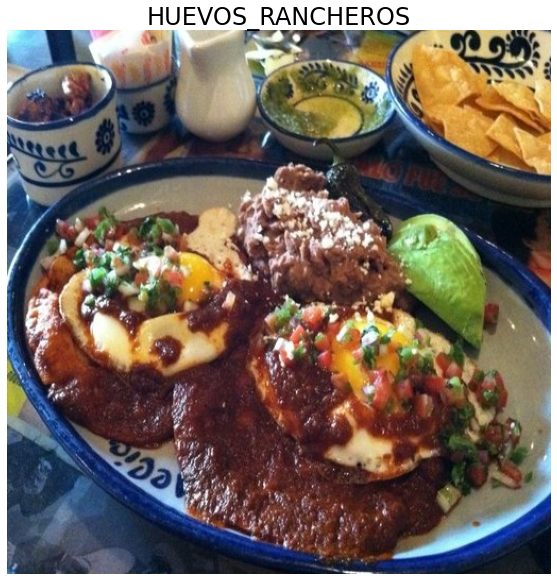

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.title(class_names[label.numpy()].upper(), fontdict={"fontsize": 24})
plt.axis(False)
plt.show()

### Creating preprocessing functions for the data

includes-
* converting uint8 datatype to float32 datatype
* reshaping the images with the same size (224, 224)
* normalizing the tensors (if needed)
* Setting up a batch size

In [ ]:
def preprocessing_image(image, label, image_shape=224, normalize=False):
  """
  Converts image datatype to float32
  reshapes the image to image_shape + (3,)
  """
  image = tf.image.resize(image, [image_shape, image_shape])
  if (normalize):
    image /= 255
  return tf.cast(image, tf.float32), label

In [ ]:
# Testing preprocessing_image function
test_image = preprocessing_image(image, label)[0]
print(f"Before:\n{image[:2]},\nshape: {image.shape},\nDatatype: {image.dtype}")
print("\n--------------------------------------------------------------\n")
print(f"After:\n{test_image[:2]},\nshape: {test_image.shape},\nDatatype: {test_image.dtype}")

Before:
[[[233 253 251]
  [231 253 250]
  [228 254 251]
  ...
  [ 85  82  89]
  [ 68  67  75]
  [ 57  57  67]]

 [[232 254 252]
  [229 254 251]
  [226 255 251]
  ...
  [121 116 120]
  [100  99 104]
  [ 86  85  91]]],
shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

--------------------------------------------------------------

After:
[[[230.65816  253.64285  251.      ]
  [222.99998  254.97449  252.19388 ]
  [207.06633  255.       250.36734 ]
  ...
  [140.66287  129.52519  121.22428 ]
  [121.14268  115.265144 116.95397 ]
  [ 83.95363   83.08119   89.63737 ]]

 [[221.47449  254.37755  253.33163 ]
  [214.5102   255.       253.92348 ]
  [198.41327  254.58673  251.96939 ]
  ...
  [208.66318  195.82143  173.40823 ]
  [197.03056  190.1071   174.83162 ]
  [175.54036  171.6169   161.21384 ]]],
shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


### Preprocessing data

In [ ]:
# Preparing whole data
train_data = train_data.map(map_func=preprocessing_image,
                            num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.map(map_func=preprocessing_image,
                          num_parallel_calls=tf.data.AUTOTUNE)

 
# turning data into batches
train_data = train_data.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)


In [ ]:
train_data

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

In [ ]:
test_data

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

## Training Base Model with EfficientNet

* Creating Callbacks
* Setting up mixed precision training
* Creating feature extraction model
* Fitting model with data

### Creating feature extraction model using EfficientNet

### Creating Callbacks

Creating:
1. TensorBoard callback
2. ModelCheckpoint callback

In [ ]:
# Creating Tensorboard callback function
import datetime

def tensorboard_callback(dir_name, save_as):
  """
  Creates a tensorboard callback to store log files.

  Filepath:
            dir_name/save_as/current_datatime/
  """

  log_dir = dir_name + "/" + save_as + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tc = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir)
  print(f"Saved tensorboard log files to: {log_dir}")
  return tc

In [ ]:
# Creating ModelCheckpoint callback
cp_path = "ModelcheckPoints/check_point.ckpt"
mcp = tf.keras.callbacks.ModelCheckpoint(cp_path,
                                         monitor="val_acc", # saving the best Valid accuracy model
                                         save_best_only=True,
                                         save_weights_olny=True)

### Setting up mixed precision training

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

In [ ]:
mixed_precision.global_policy()

<Policy "mixed_float16">

### Creating feature extraction model using EfficientNet

In [ ]:
# setting up base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # Freezing base_model layers

# Creating functional model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_avg_pooling_2d_layer")(x)
x = tf.keras.layers.Dense(len(class_names))(x)
outputs = tf.keras.layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)

model_1 = tf.keras.Model(inputs, outputs)

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
# Compiling Model_1
model_1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Viewing the summary of the model
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pooling_2d_layer  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
# verifying the layers
for layer in model_1.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_avg_pooling_2d_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
for layer in model_1.layers[1].layers[:10]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">


### Fitting the data into model

In [ ]:
# Fitting data into the model
his_1 = model_1.fit(train_data,
            epochs=5,
            steps_per_epoch=len(train_data),
            validation_data=test_data,
            validation_steps=0.15 * len(test_data),
            callbacks=[tensorboard_callback("tensorboard_callback", "base_model_1"),
                       mcp])

Saved tensorboard log files to: tensorboard_callback/base_model_1/20211207-082802


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/5
2368/2368 [==============================] - ETA: 0s - loss: 1.8219 - accuracy: 0.5573WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 273s 106ms/step - loss: 1.8219 - accuracy: 0.5573 - val_loss: 1.2344 - val_accuracy: 0.6746
Epoch 2/5
2367/2368 [============================>.] - ETA: 0s - loss: 1.2926 - accuracy: 0.6673WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 240s 101ms/step - loss: 1.2925 - accuracy: 0.6674 - val_loss: 1.1232 - val_accuracy: 0.7043
Epoch 3/5
2367/2368 [============================>.] - ETA: 0s - loss: 1.1430 - accuracy: 0.7018WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 240s 101ms/step - loss: 1.1431 - accuracy: 0.7018 - val_loss: 1.0836 - val_accuracy: 0.7064
Epoch 4/5
2367/2368 [============================>.] - ETA: 0s - loss: 1.0444 - accuracy: 0.7268WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 240s 101ms/step - loss: 1.0443 - accuracy: 0.7268 - val_loss: 1.0720 - val_accuracy: 0.7106
Epoch 5/5
2367/2368 [============================>.] - ETA: 0s - loss: 0.9726 - accuracy: 0.7455WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 250s 105ms/step - loss: 0.9727 - accuracy: 0.7454 - val_loss: 1.0511 - val_accuracy: 0.7169
